# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [6]:
data = pd.read_csv("/kaggle/input/nlp-class/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [7]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


<Axes: >

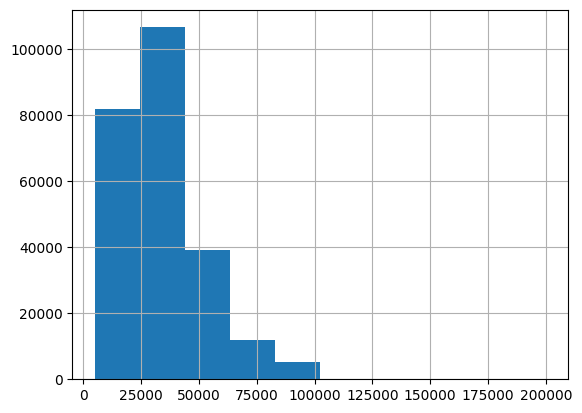

In [9]:
data['SalaryNormalized'].hist()

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

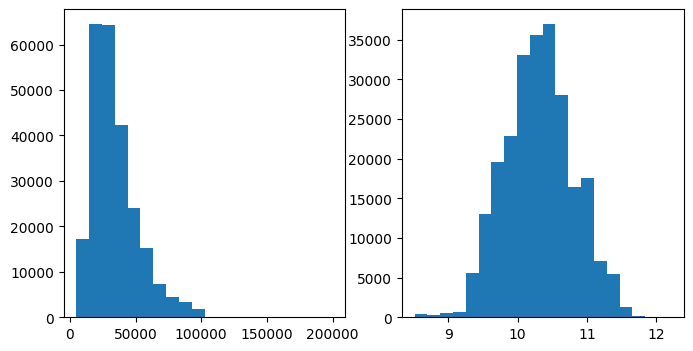

In [10]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [11]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
12924,66583754,Data Analyst Northamptonshire,Data Analyst My telecoms client is urgently se...,Northamptonshire,Northamptonshire,NaN,contract,Randstad,Engineering Jobs,130 - 140 per day,32400,rengineeringjobs.com,10.385944
95807,69220806,Customer Community Officer Kent ****k car all...,Our client who are one of the largest maintena...,UK,UK,full_time,permanent,Potensis,Other/General Jobs,"From 22,000 to 27,000 per year + car allowance...",24500,fish4.co.uk,10.106469
217778,72293755,Oracle EBusiness Suite (EBS) Support Analyst,An Oracle EBS Support Analyst is required by a...,Bedfordshire Bedfordshire England,Bedfordshire,NaN,NaN,Redrock Consulting,IT Jobs,45000 -55000 per annum,50000,gojobsearch.co.uk,10.819798


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [12]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [13]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

def convert_to_tokens(text):
  text = str(text)
  return (' '.join(tokenizer.tokenize(text))).lower()

data['Title'] = data['Title'].apply(convert_to_tokens)


In [14]:
data['FullDescription'] = data['FullDescription'].apply(convert_to_tokens)

Now we can assume that our text is a space-separated list of tokens:

In [15]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [16]:
from collections import Counter
token_counts = Counter()
for string in data['Title']:
  token_counts.update(string.split())
for string in data['FullDescription']:
  token_counts.update(string.split())


# Count how many times does each token occur in both "Title" and "FullDescription" in total

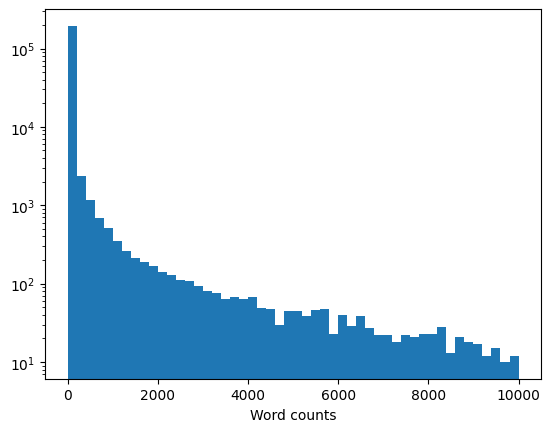

In [18]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [19]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count > min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [20]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [21]:
token_to_id = {token: index for index, token in enumerate(tokens)}


In [22]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [23]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [25]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [26]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [103]:
class Encoder(nn.Module):
  def __init__(self, out_channels, n_tokens=len(tokens), hid_size=64, 
               kernel=5, normalize=False, relu=None, padding=0):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
    self.conv1 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv2 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.normalize=normalize
    if self.normalize:
      self.normalization = nn.BatchNorm1d(2*out_channels)
    self.relu = relu


  def forward(self, x):
    out = self.emb(x).transpose(-1, -2)
    out = torch.cat((self.conv1(out), self.conv2(out)), dim=1)
    if self.normalize:
      out = self.normalization(out)
    if self.relu:
      out = self.relu(out)
    out, _ = torch.max(out, dim=-1)
    return out


class CategoricalEncoder(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 out_channels=128):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Linear(n_cat_features, out_channels),
        )
    def forward(self, x):
        return self.layers(x)
        


class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_channels=128, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, kernel=5, normalize=False, relu=None):
        super().__init__()
        self.out_channels = out_channels
        self.title_encoder = Encoder(self.out_channels, n_tokens, hid_size,
                                     kernel=kernel-3, normalize=normalize,
                                     relu=relu, padding=1)
        self.description_encoder = Encoder(self.out_channels, n_tokens, hid_size,kernel=kernel, normalize=normalize, relu=relu)
        self.categorical_encoder = CategoricalEncoder()
        self.first_fc = nn.Linear(5 * self.out_channels, 64)
        self.norm = nn.BatchNorm1d(64)
        self.activation = nn.ReLU()
        self.final_fc = nn.Linear(64, 1)

    def forward(self, batch):
        # type(batch) = dict
        title = self.title_encoder(batch["Title"])
        description = self.description_encoder(batch["FullDescription"])
        categorical = self.categorical_encoder(batch["Categorical"])
        out = torch.cat((title, description, categorical), dim=1)
        out = self.first_fc(out)
        out = self.activation(self.norm(out))
        out = self.final_fc(out) # batch_size x 1
        return out.view(-1)



#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [32]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [33]:
device

'cuda'

In [34]:
from tqdm.auto import tqdm

BATCH_SIZE = 64
EPOCHS = 7

In [35]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_loss(val_loss,  name='base'):
    clear_output(wait=True)
    print(val_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(val_loss, label='val', color='blue')

    plt.title(f'model_ {name}')
    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [36]:
def print_metrics(model, data, val_loss, batch_size=BATCH_SIZE,  name="", device=torch.device('cpu')):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    val_loss.append(mae)
    plot_loss(val_loss, name=name)


In [37]:
def train(model, criterion,  optimizer, val_loss, name='base', scheduler=None):
  for epoch in range(EPOCHS):
      num_samples = 0
      print(f"epoch: {epoch}")
      model.train()
      train_loss = []
      for i, batch in tqdm(enumerate(
              iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
              total=len(data_train) // BATCH_SIZE
          ):
          pred = model(batch)
          loss = criterion(pred, batch[TARGET_COLUMN])
          num_samples += len(pred)
          #print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      if scheduler:
        scheduler.step()
      print_metrics(model, data_val, device=device, val_loss=val_loss, name=name)
  return val_loss



# Model 1 -- Base

[0.2549102816866344, 0.193304875495363, 0.18775472334359808, 0.16347537356497938, 0.16287057269324265, 0.16432269922720819, 0.16366927370592801]


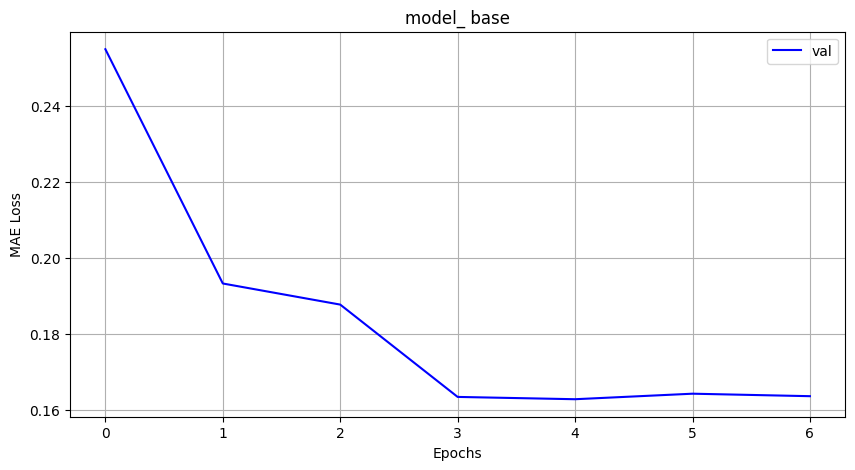

[0.2549102816866344,
 0.193304875495363,
 0.18775472334359808,
 0.16347537356497938,
 0.16287057269324265,
 0.16432269922720819,
 0.16366927370592801]

In [106]:
model = SalaryPredictor(normalize=False, relu=None).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,6], gamma=0.1)
val_loss_base = []
train(model, criterion,  optimizer, val_loss_base, name='base', scheduler=scheduler)

# Model 2 -- Add BatchNorm + ReLU

[0.20590287885055358, 0.19743317307446787, 0.17375621039011113, 0.19047513035196306, 0.1609536743039384, 0.16162448500760918, 0.16099222492352513]


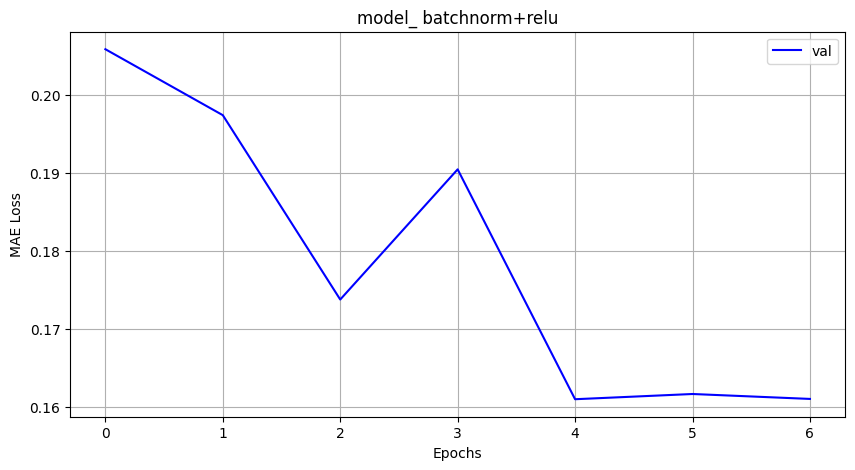

[0.20590287885055358,
 0.19743317307446787,
 0.17375621039011113,
 0.19047513035196306,
 0.1609536743039384,
 0.16162448500760918,
 0.16099222492352513]

In [107]:
model_2 = SalaryPredictor(normalize=True, relu=nn.ReLU()).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model_2.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,4,6], gamma=0.1)

val_loss_batch_relu = []
train(model_2, criterion,  optimizer, val_loss_batch_relu, name='batchnorm+relu', scheduler=scheduler)

# Model 3 -- 3conv + batch + ReLU

In [89]:
class Encoder(nn.Module):
  def __init__(self, out_channels, n_tokens=len(tokens), hid_size=64, 
               kernel=5, normalize=False, relu=None, padding=0):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
    self.conv1 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv2 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv3 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)

    self.normalize=normalize
    if self.normalize:
      self.normalization = nn.BatchNorm1d(3*out_channels)
    self.relu = relu


  def forward(self, x):
    out = self.emb(x).transpose(-1, -2)
    out1 = self.conv1(out)
    out2 = self.conv2(out)
    out3 = self.conv3(out)
    out = torch.cat((out1, out2, out3), dim=1)
    if self.normalize:
      out = self.normalization(out)
    if self.relu:
      out = self.relu(out)
    out, _ = torch.max(out, dim=-1)
    return out


class CategoricalEncoder(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 out_channels=128):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Linear(n_cat_features, out_channels),
        )
    def forward(self, x):
        return self.layers(x)
        


class SalaryPredictor_3conv(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_channels=128, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, kernel=5, normalize=False, relu=None):
        super().__init__()
        self.out_channels = out_channels
        self.title_encoder = Encoder(self.out_channels, n_tokens, hid_size, 
                                     kernel=kernel-3, normalize=normalize,
                                     relu=relu, padding=1)
        self.description_encoder = Encoder(self.out_channels, n_tokens, hid_size,kernel=kernel, normalize=normalize, relu=relu)
        self.categorical_encoder = CategoricalEncoder()
        self.first_fc = nn.Linear(7 * self.out_channels, 64)
        self.norm = nn.BatchNorm1d(64)
        self.activation = nn.ReLU()
        self.final_fc = nn.Linear(64, 1)

    def forward(self, batch):
        # type(batch) = dict
        title = self.title_encoder(batch["Title"])
        description = self.description_encoder(batch["FullDescription"])
        categorical = self.categorical_encoder(batch["Categorical"])
        out = torch.cat((title, description, categorical), dim=1)
        out = self.first_fc(out)
        out = self.activation(self.norm(out))
        out = self.final_fc(out) # batch_size x 1
        return out.view(-1)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.22831173062339136, 0.17161301537540344, 0.16335857466320422, 0.16014463992983208, 0.15951869356947337, 0.1588133718324856, 0.15921336069320177]


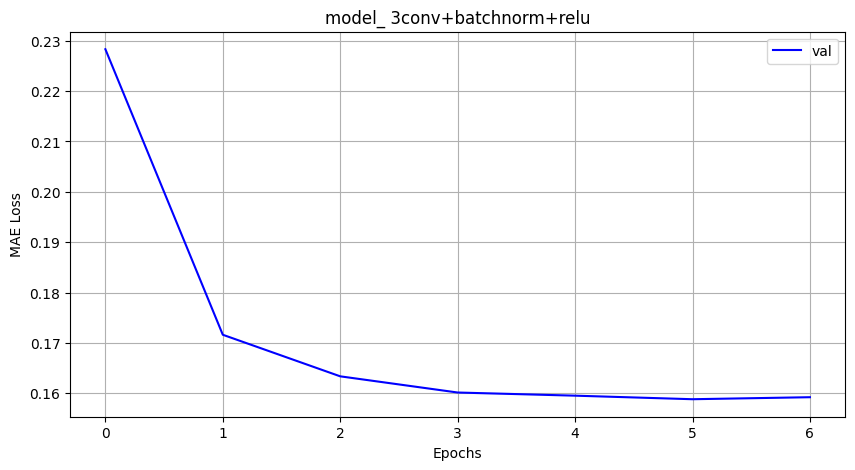

[0.22831173062339136,
 0.17161301537540344,
 0.16335857466320422,
 0.16014463992983208,
 0.15951869356947337,
 0.1588133718324856,
 0.15921336069320177]

In [90]:
model_3conv = SalaryPredictor_3conv(normalize=True, relu=nn.ReLU()).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model_3conv.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)

val_loss_3conv = []
train(model_3conv, criterion,  optimizer, val_loss_3conv, name='3conv+batchnorm+relu', scheduler=scheduler)

# Model 4 -- with softmax_pooling instead of MaxPooling




In [59]:
def softmax_pooling(x):
  w = torch.softmax(x, dim=-1)
  result = (x * w).sum(dim=-1)
  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
class Encoder(nn.Module):
  def __init__(self, out_channels, n_tokens=len(tokens), hid_size=64, 
               kernel=5, normalize=False, relu=None, padding=0):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
    self.conv1 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv2 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv3 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)

    self.normalize=normalize
    if self.normalize:
      self.normalization = nn.BatchNorm1d(3*out_channels)
    self.relu = relu


  def forward(self, x):
    out = self.emb(x).transpose(-1, -2)
    out1 = self.conv1(out)
    out2 = self.conv2(out)
    out3 = self.conv3(out)
    out = torch.cat((out1, out2, out3), dim=1)
    if self.normalize:
      out = self.normalization(out)
    if self.relu:
      out = self.relu(out)
    out = softmax_pooling(out)
    return out


class CategoricalEncoder(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 out_channels=128):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Linear(n_cat_features, out_channels),
        )
    def forward(self, x):
        return self.layers(x)
        


class SalaryPredictor_soft(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_channels=128, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, kernel=5, normalize=False, relu=None):
        super().__init__()
        self.out_channels = out_channels
        self.title_encoder = Encoder(self.out_channels, n_tokens, 
                                     hid_size, kernel=kernel-3, normalize=normalize,
                                     relu=relu, padding=1)
        self.description_encoder = Encoder(self.out_channels, n_tokens, hid_size,kernel=kernel, normalize=normalize, relu=relu)
        self.categorical_encoder = CategoricalEncoder()
        self.first_fc = nn.Linear(7 * self.out_channels, 64)
        self.norm = nn.BatchNorm1d(64)
        self.activation = nn.ReLU()
        self.final_fc = nn.Linear(64, 1)

    def forward(self, batch):
        # type(batch) = dict
        title = self.title_encoder(batch["Title"])
        description = self.description_encoder(batch["FullDescription"])
        categorical = self.categorical_encoder(batch["Categorical"])
        out = torch.cat((title, description, categorical), dim=1)
        out = self.first_fc(out)
        out = self.activation(self.norm(out))
        out = self.final_fc(out) # batch_size x 1
        return out.view(-1)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.23763342005377497, 0.17823859516076315, 0.19752527564141847, 0.16872661628135596, 0.16912050087837563, 0.16908922151407443, 0.16997964607080115]


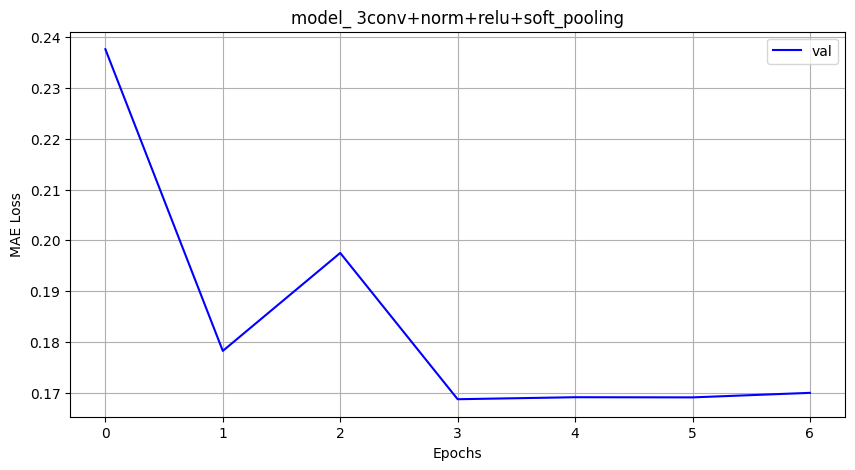

[0.23763342005377497,
 0.17823859516076315,
 0.19752527564141847,
 0.16872661628135596,
 0.16912050087837563,
 0.16908922151407443,
 0.16997964607080115]

In [88]:
model_soft_max = SalaryPredictor_soft(normalize=True, relu=nn.ReLU()).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model_soft_max.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)

val_loss_soft_pool = []
train(model_soft_max, criterion,  optimizer, val_loss_soft_pool, name='3conv+norm+relu+soft_pooling', scheduler=scheduler)

# Model 5 -- with softmax_pooling instead of MaxPooling + LeakyReLU


[0.20133599191971033, 0.178907670338481, 0.1766593662864628, 0.17020825673080853, 0.16878506560367895, 0.1690118609434367, 0.17021491955458184]


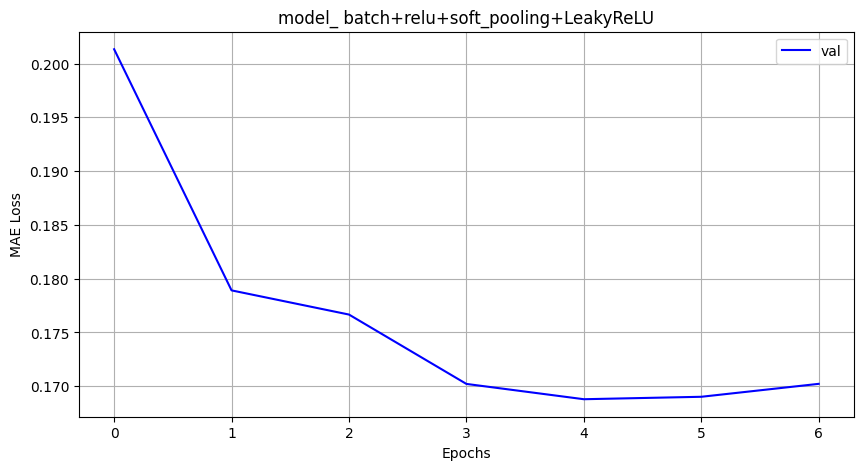

[0.20133599191971033,
 0.178907670338481,
 0.1766593662864628,
 0.17020825673080853,
 0.16878506560367895,
 0.1690118609434367,
 0.17021491955458184]

In [96]:
model_soft_max_lrelu = SalaryPredictor_soft(normalize=True, relu=nn.LeakyReLU(0.2)).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model_soft_max_lrelu.parameters(), lr=1e-2)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)

val_loss_soft_pool_lrelu = []
train(model_soft_max_lrelu, criterion,  optimizer, val_loss_soft_pool_lrelu, name='batch+relu+soft_pooling+LeakyReLU',
     scheduler=scheduler)

Поскольку 2 модель показала лучшее качество, будем использовать ее


# Model 5 the same embeddings in title and desc encoders

In [85]:
class Embeddings(nn.Module):
  def __init__(self, n_tokens=len(tokens), hid_size=64):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)

  def forward(self, x):
    return self.emb(x)


class Encoder(nn.Module):
  def __init__(self, out_channels, n_tokens=len(tokens), hid_size=64, 
               kernel=5, normalize=False, relu=None, embeddings=None, padding=0):
    super().__init__()
    self.emb = embeddings
    self.conv1 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv2 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)
    self.conv3 = nn.Conv1d(hid_size, out_channels, kernel_size=kernel, padding=padding)

    self.normalize=normalize
    if self.normalize:
      self.normalization = nn.BatchNorm1d(3*out_channels)
    self.relu = relu


  def forward(self, x):
    out = self.emb(x).transpose(-1, -2)
    out1 = self.conv1(out)
    out2 = self.conv2(out)
    out3 = self.conv3(out)
    out = torch.cat((out1, out2, out3), dim=1)
    if self.normalize:
      out = self.normalization(out)
    if self.relu:
      out = self.relu(out)
    out, _ = torch.max(out, dim=-1)
    return out


class CategoricalEncoder(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 out_channels=128):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Linear(n_cat_features, out_channels),
        )
    def forward(self, x):
        return self.layers(x)
        


class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_channels=128, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, kernel=5, normalize=False, relu=None, embeddings=None):
        super().__init__()
        self.out_channels = out_channels
        self.title_encoder = Encoder(self.out_channels, n_tokens, hid_size, kernel=kernel-3, 
                                     normalize=normalize, relu=relu, embeddings=embeddings, padding=1)
        self.description_encoder = Encoder(self.out_channels, n_tokens, hid_size,kernel=kernel,
                                           normalize=normalize, relu=relu, embeddings=embeddings)
        self.categorical_encoder = CategoricalEncoder()
        self.first_fc = nn.Linear(7 * self.out_channels, 64)
        self.norm = nn.BatchNorm1d(64)
        self.activation = nn.ReLU()
        self.final_fc = nn.Linear(64, 1)

    def forward(self, batch):
        # type(batch) = dict
        title = self.title_encoder(batch["Title"])
        description = self.description_encoder(batch["FullDescription"])
        categorical = self.categorical_encoder(batch["Categorical"])
        out = torch.cat((title, description, categorical), dim=1)
        out = self.first_fc(out)
        out = self.activation(self.norm(out))
        out = self.final_fc(out) # batch_size x 1
        return out.view(-1)



[0.1953107445254729, 0.18007386398455694, 0.16640867175690444, 0.16503896275712915, 0.16240612998937778, 0.16259550180398946, 0.16246454938883953]


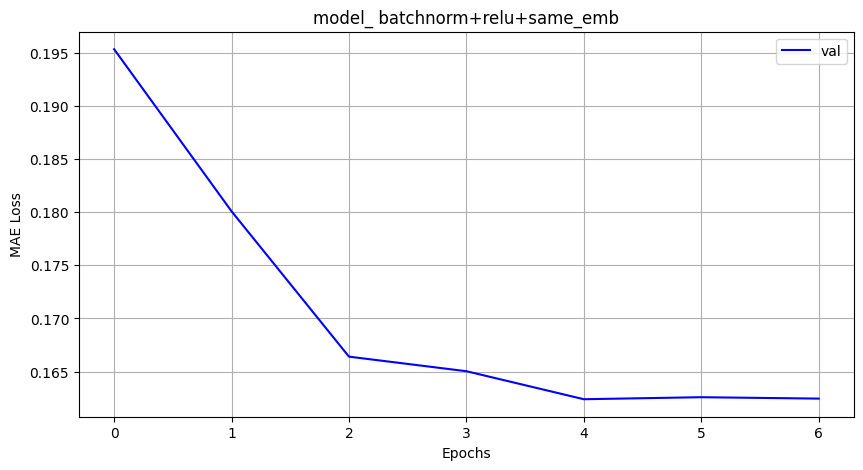

[0.1953107445254729,
 0.18007386398455694,
 0.16640867175690444,
 0.16503896275712915,
 0.16240612998937778,
 0.16259550180398946,
 0.16246454938883953]

In [86]:
embeddings = Embeddings().to(device)
model_6 = SalaryPredictor(normalize=True, relu=nn.ReLU(), embeddings=embeddings).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model_6.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)

val_loss_batch_relu_same_emb = []
train(model_6, criterion,  optimizer, val_loss_batch_relu_same_emb,
      name='batchnorm+relu+same_emb', scheduler=scheduler)

# Results

In [15]:
import matplotlib.pyplot as plt

def plot_loss(val_loss):
    
    plt.figure(figsize=(10, 5))
    for name, loss in val_loss.items():  
        plt.plot(loss, label=name)

    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid()
    plt.show()


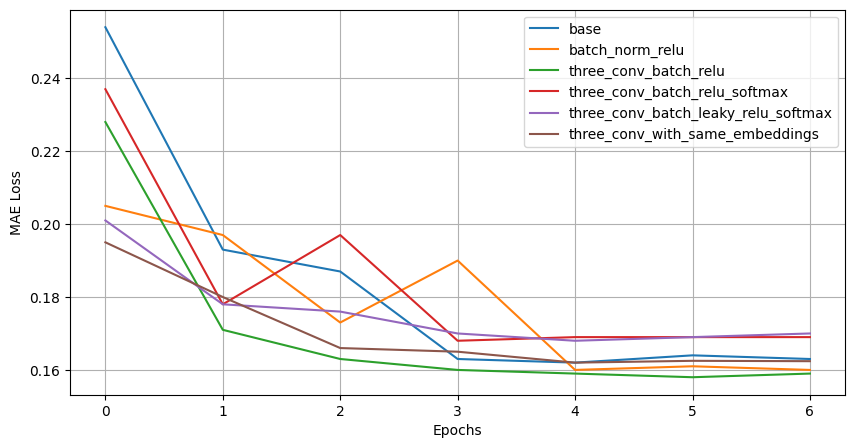

In [16]:
val_loss = {}
val_loss['base'] = [0.254, 0.193, 0.187, 0.163, 0.162, 0.164, 0.163]
val_loss['batch_norm_relu'] = [0.205,0.197, 0.173, 0.190, 0.160, 0.161, 0.160]
val_loss['three_conv_batch_relu'] = [0.228, 0.171, 0.163, 0.160, 0.159, 0.158, 0.159]
val_loss['three_conv_batch_relu_softmax'] = [0.237, 0.178, 0.197, 0.168, 0.169, 0.169, 0.169]
val_loss['three_conv_batch_leaky_relu_softmax'] = [0.201, 0.178, 0.176, 0.170, 0.168, 0.169, 0.170]
val_loss['three_conv_with_same_embeddings']= [0.195, 0.180, 0.166, 0.165, 0.162, 0.1625, 0.1624]
plot_loss(val_loss)

We trained 5 different models using MultiStep scheduler and AdamW with initial learning rate = 1e-2 as an optimizer.

Base model consists of 2 convolutional layers, Linear layers and MaxPooling, we didn't use batch norm or activation after convolutional layers there. The kernel size in convolutional layers was 5 (in the Description Encoder) and 2 with padding = 1 (in the Title Encoder). According to our data, the length of the title can be less than 3 words, this is why we used kernel_size = 2 with padding = 1. On the contrary, the description consists of a large number of words, so we decided to use kernel size = 5 to catch more context in our data.

We complicated the next models adding batch normalization, some activations(ReLU, LeakyReLU), softMax instead of MaxPooling and tried to use the same embeddings in Title and Description Encoder.

As we can see on the plot above, the best model is a model with three convolutional layers, batch normalization and ReLU as an activation function. It achieved a 0.158 MAE score.

The base model with batch normalization and ReLU came with the second result, achieving a MAE score of 0.160.

The same results showed the base model and a model with the same embeddings (0.162 MAE), but the training of models with the same embeddings was more stable.  

It turned out that the worst models are models using softmax pooling instead of MaxPooling, we trained it using ReLU and LeakyReLU activation, but the result was bad.

